```
WARNING: Not DRY! Repetition ahead. Learning in progress.
```

# Imports and setup

In [1]:
from pathlib import Path
from typing import Generator

import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_circles

import torch
from torch import nn

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# 0. Plot and data helpers

In [2]:
def plot_decision_boundary(model: nn.Module, X: torch.Tensor, y: torch.Tensor) -> None:
    model = model.cpu()
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    X_new = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_new)

    y_probs = 1 / (1 + torch.exp(-y_logits))
    y_preds = torch.round(y_probs)

    y_preds = y_preds.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_preds, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


def plot_roc_auc(all_probs: torch.Tensor, all_labels: torch.Tensor) -> None:
    thresholds = np.sort(np.unique(all_probs.detach().cpu().numpy()))

    tpr_list = []
    fpr_list = []

    for t in thresholds:
        preds = (all_probs >= t).int()

        TP = ((preds == 1) & (all_labels == 1)).sum().item()
        TN = ((preds == 0) & (all_labels == 0)).sum().item()
        FP = ((preds == 1) & (all_labels == 0)).sum().item()
        FN = ((preds == 0) & (all_labels == 1)).sum().item()

        TPR = TP / (TP + FN)
        FPR = FP / (FP + TN)

        tpr_list.append(TPR)
        fpr_list.append(FPR)

    tpr_list = [0] + tpr_list + [1]
    fpr_list = [0] + fpr_list + [1]

    fpr_np = np.array(fpr_list)
    tpr_np = np.array(tpr_list)
    sort_idx = np.argsort(fpr_np)
    roc_auc = np.trapezoid(tpr_np[sort_idx], fpr_np[sort_idx])
    
    plt.plot(fpr_list, tpr_list, linestyle="-", color="b", label=f"ROC Curve (AUC={roc_auc:.4f})", lw=0.8)
    plt.plot([0,1], [0,1], linestyle="--", color="r", label="Random")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()


def plot_confusion_matrix(all_probs: torch.Tensor, all_labels: torch.Tensor) -> None:
    preds = torch.round(all_probs)

    TP = ((preds == 1) & (all_labels == 1)).sum().item()
    TN = ((preds == 0) & (all_labels == 0)).sum().item()
    FP = ((preds == 1) & (all_labels == 0)).sum().item()
    FN = ((preds == 0) & (all_labels == 1)).sum().item()

    confmat = [[TN, FP],
               [FN, TP]]

    sns.heatmap(confmat, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")


def plot_train_val_metrics(
            total_train_loss: list[float], 
            total_val_loss: list[float], 
            total_train_f1: list[float], 
            total_val_f1: list[float],
            total_train_recall: list[float], 
            total_val_recall: list[float],
            total_train_precision: list[float], 
            total_val_precision: list[float],
            total_train_acc: list[float], 
            total_val_acc: list[float],
) -> None:
    plt.figure(figsize=(15, 8)) 
    metrics = {
        "loss": [total_train_loss, total_val_loss],
        "f1": [total_train_f1, total_val_f1],
        "recall": [total_train_recall, total_val_recall],
        "precision": [total_train_precision, total_val_precision],
        "acc": [total_train_acc, total_val_acc],
    }

    for i, key in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        plt.plot(metrics[key][0], label=f"training {key}")
        plt.plot(metrics[key][1], label=f"validation {key}")
        plt.title(f"Training and validation {key} over epochs")
        plt.xlabel("Epochs")
        plt.ylabel(key)
        if key != "loss":
            plt.ylim([0.0, 1.0])
        plt.legend()
    plt.tight_layout()
    plt.show()
    

In [3]:
def check_confidence(all_probs: torch.Tensor, all_labels: torch.Tensor, threshold: float=0.5) -> None:
    preds = (all_probs >= threshold).int()
    misclassified = preds != all_labels

    high_confidence_errors = misclassified & ((preds > 0.8) | (preds < 0.2))
    low_confidence_errors = misclassified & ((preds < threshold + 0.05) | (preds > threshold + 0.05))

    print(f"Number of hight confidence errors: {high_confidence_errors.sum().item()}")
    print(f"Number of low confidence errors: {low_confidence_errors.sum().item()}")

In [4]:
def manual_dataloader(dataset: list[tuple], batch_size: int=32, shuffle: bool=False) -> Generator[tuple[torch.Tensor, torch.Tensor] | torch.Tensor, None, None]:
    indices = torch.arange(len(dataset))

    if shuffle:
        indices = indices[torch.randperm(len(dataset))]

    for i in range(0, len(dataset), batch_size):
        batch_idx = indices[i: i+batch_size]
        batch = [dataset[j] for j in batch_idx]
        if isinstance(batch[0], tuple):  
            batch_x = torch.stack([b[0] for b in batch])   
            batch_y = torch.stack([b[1] for b in batch])
            yield batch_x, batch_y
        else:
            batch_x = torch.stack(batch)
            yield batch_x

# 1. Balanced dataset workflow

# 1.1 Prepare dataset

In [5]:
N_SAMPLES = 1000
NOISE = 0.2
FACTOR = 0.3
RANDOM_STATE = 42

X_data, y_data = make_circles(
    n_samples=N_SAMPLES,
    noise=NOISE,
    random_state=RANDOM_STATE,
    factor=FACTOR
)

data = pd.DataFrame({
    "X1": X_data[:, 0],
    "X2": X_data[:, 1],
    "y": y_data
})
data[:5]

,X1,X2,y
0,0.169221,0.230303,1
1,-0.074740,0.203119,1
2,-0.442302,0.524370,1
3,-0.481782,0.064922,1
4,0.471062,-0.881526,0


## 1.2 Visualize

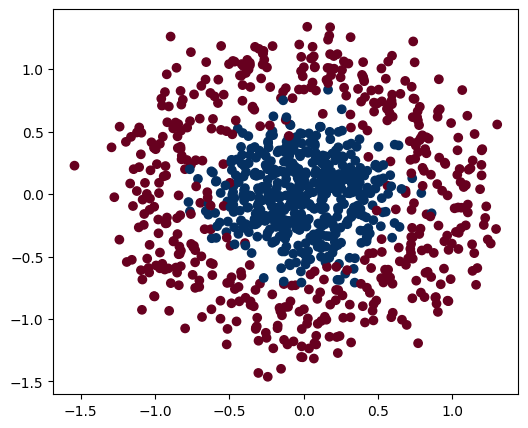

In [6]:
plt.figure(figsize=(6, 5))
plt.scatter(X_data[:, 0], X_data[:, 1], c=y_data, cmap=plt.cm.RdBu);

## 1.3 Train / val / test split

In [7]:
X_data = torch.tensor(X_data, dtype=torch.float32)
y_data = torch.tensor(y_data, dtype=torch.float32).view(-1, 1)

n_samples = X_data.shape[0]
indices = torch.arange(n_samples)

test_split = int(0.2 * n_samples)
trainval_split = n_samples - test_split
val_split = int(0.3 * trainval_split)
train_split = trainval_split - val_split

test_idx = indices[:test_split]
trainval_idx  = indices[test_split:]
train_idx = trainval_idx[:train_split]
val_idx = trainval_idx[train_split:]

X_test, y_test = X_data[test_idx], y_data[test_idx]
X_val, y_val = X_data[val_idx], y_data[val_idx]
X_train, y_train = X_data[train_idx], y_data[train_idx]

print(f"Shape of X_train: {X_train.shape} and y_train: {y_train.shape}")
print(f"Shape of X_val: {X_val.shape} and y_val: {y_val.shape}")
print(f"Shape of X_test: {X_test.shape} and y_test: {y_test.shape}")

Shape of X_train: torch.Size([560, 2]) and y_train: torch.Size([560, 1])
Shape of X_val: torch.Size([240, 2]) and y_val: torch.Size([240, 1])
Shape of X_test: torch.Size([200, 2]) and y_test: torch.Size([200, 1])


## 1.4 Dataset 

In [8]:
train_dataset = [(X_train[i], y_train[i]) for i in range(len(X_train))]
val_dataset = [(X_val[i], y_val[i]) for i in range(len(X_val))]
test_dataset = [(X_test[i], y_test[i]) for i in range(len(X_test))]

## 1.5 CircleModelV0

### 1.5.1 Model

In [9]:
class CircleModelV0(nn.Module):
    """
    Simple neural network with only linear layers.
    """
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=12),
            nn.Linear(in_features=12, out_features=1)
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=12, bias=True)
    (1): Linear(in_features=12, out_features=1, bias=True)
  )
)

### 1.5.2 Loss function and optimizer

In [10]:
loss_fn = nn.BCEWithLogitsLoss(reduction="none")
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.01)

### 1.5.3 Training

In [11]:
N_EPOCHS = 200
BATCH_SIZE = 32
eps = 1e-8

total_train_loss = []
total_train_acc = []
total_train_f1 = []
total_train_recall = []
total_train_precision = []

total_val_loss = []
total_val_acc = []
total_val_f1 = []
total_val_recall = []
total_val_precision = []


for epoch in range(N_EPOCHS):

    train_loss = []
    total_samples = 0
    TN_train, TP_train, FN_train, FP_train = 0, 0, 0, 0 
    
    train_dataloader = manual_dataloader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    model_0.train()
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)
        train_logits = model_0(X)
        losses = loss_fn(train_logits, y)
        train_loss.extend(losses.flatten().tolist())

        optimizer.zero_grad()
        losses.mean().backward()
        optimizer.step()

        probs = 1 / (1 + torch.exp(-train_logits))
        preds = torch.round(probs)

        TN_train += ((preds == 0) & (y == 0)).sum().item()
        TP_train += ((preds == 1) & (y == 1)).sum().item()
        FN_train += ((preds == 0) & (y == 1)).sum().item()
        FP_train += ((preds == 1) & (y == 0)).sum().item()

        total_samples += len(y)

    recall = TP_train / (TP_train + FN_train + eps)
    precision = TP_train / (TP_train + FP_train + eps)
    f1 = 2 * recall * precision / (recall + precision + eps)
    acc = (TP_train + TN_train) / total_samples
    
    mean_train_loss = sum(train_loss) / len(train_loss)
    total_train_loss.append(mean_train_loss)
    total_train_recall.append(recall)
    total_train_precision.append(precision)
    total_train_f1.append(f1)
    total_train_acc.append(acc)

    val_loss = []
    total_samples = 0
    TN_val, TP_val, FN_val, FP_val = 0, 0, 0, 0
    
    val_dataloader = manual_dataloader(val_dataset, batch_size=BATCH_SIZE)
    model_0.eval()
    with torch.inference_mode():
        for X, y in val_dataloader:
            X, y = X.to(device), y.to(device)
            val_logits = model_0(X)
            losses = loss_fn(val_logits, y)
            val_loss.extend(losses.flatten().tolist())

            probs = 1 / (1 + torch.exp(-val_logits))
            preds = torch.round(probs)

            TN_val += ((preds == 0) & (y == 0)).sum().item()
            TP_val += ((preds == 1) & (y == 1)).sum().item()
            FN_val += ((preds == 0) & (y == 1)).sum().item()
            FP_val += ((preds == 1) & (y == 0)).sum().item()

            total_samples += len(y)

    recall = TP_val / (TP_val + FN_val + eps)
    precision = TP_val / (TP_val + FP_val + eps)
    f1 = 2 * recall * precision / (recall + precision + eps)
    acc = (TP_val + TN_val) / total_samples
    mean_val_loss = sum(val_loss) / len(val_loss)
    total_val_loss.append(mean_val_loss)
    total_val_recall.append(recall)
    total_val_precision.append(precision)
    total_val_f1.append(f1)
    total_val_acc.append(acc)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{N_EPOCHS}: val_loss={mean_val_loss:.4f} | val_acc={acc:.4f}")

Epoch 0/200: val_loss=0.6963 | val_acc=0.5833
Epoch 10/200: val_loss=0.6931 | val_acc=0.3958
Epoch 20/200: val_loss=0.6946 | val_acc=0.4792
Epoch 30/200: val_loss=0.6948 | val_acc=0.4792
Epoch 40/200: val_loss=0.6949 | val_acc=0.4792
Epoch 50/200: val_loss=0.6947 | val_acc=0.4417
Epoch 60/200: val_loss=0.6947 | val_acc=0.3875
Epoch 70/200: val_loss=0.6944 | val_acc=0.3625
Epoch 80/200: val_loss=0.6946 | val_acc=0.3542
Epoch 90/200: val_loss=0.6946 | val_acc=0.3625
Epoch 100/200: val_loss=0.6946 | val_acc=0.3542
Epoch 110/200: val_loss=0.6946 | val_acc=0.3583
Epoch 120/200: val_loss=0.6946 | val_acc=0.3625
Epoch 130/200: val_loss=0.6949 | val_acc=0.3667
Epoch 140/200: val_loss=0.6947 | val_acc=0.3583
Epoch 150/200: val_loss=0.6946 | val_acc=0.3542
Epoch 160/200: val_loss=0.6948 | val_acc=0.3542
Epoch 170/200: val_loss=0.6949 | val_acc=0.3500
Epoch 180/200: val_loss=0.6953 | val_acc=0.3500
Epoch 190/200: val_loss=0.6947 | val_acc=0.3500


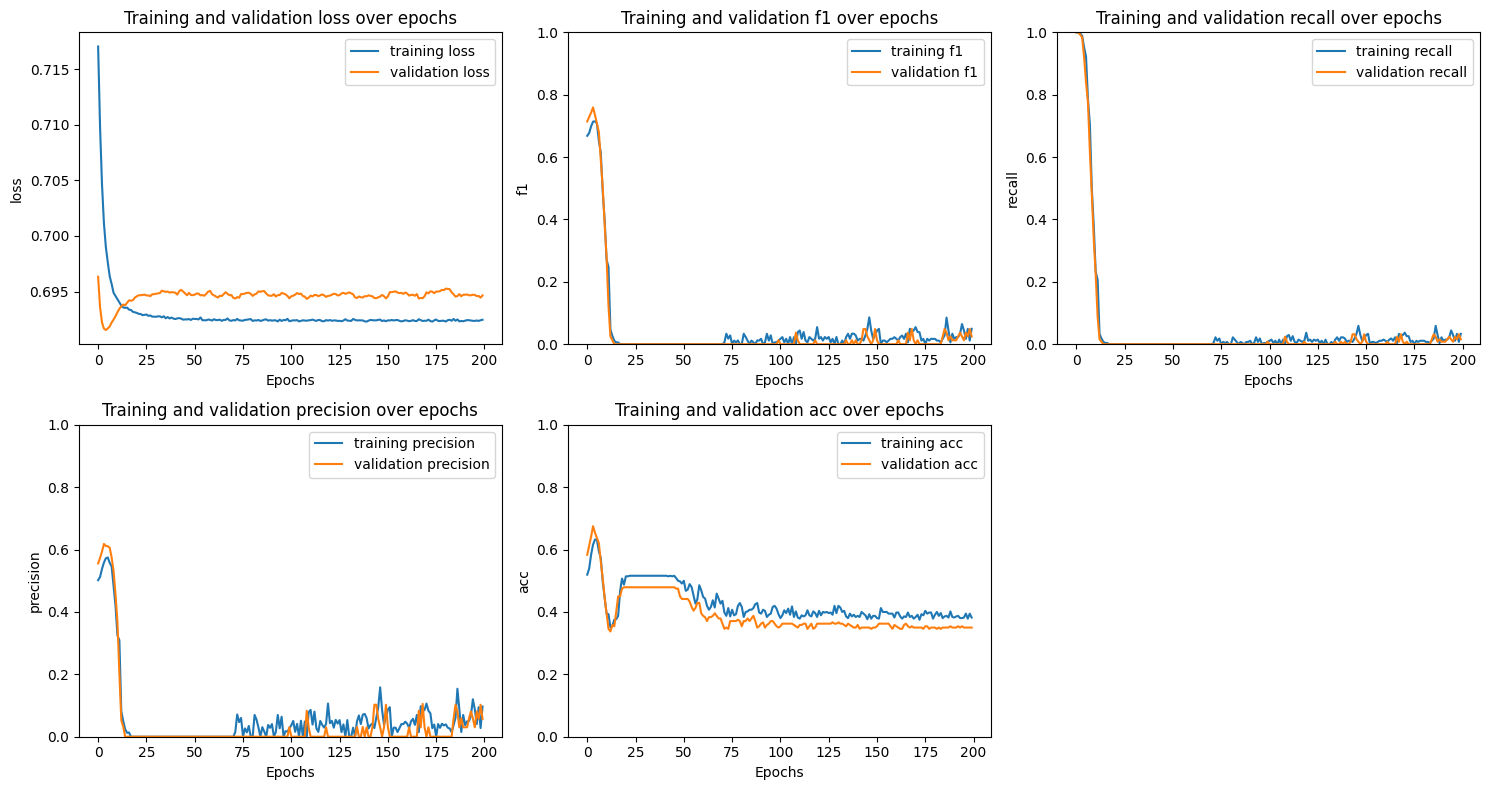

In [12]:
plot_train_val_metrics(
            total_train_loss,
            total_val_loss,
            total_train_f1, 
            total_val_f1,
            total_train_recall,
            total_val_recall,
            total_train_precision,
            total_val_precision,
            total_train_acc,
            total_val_acc,
)

### 1.5.4 Testing

In [13]:
eps = 1e-8
test_loss = []
all_probs = []
all_labels = []
TP_total, TN_total, FP_total, FN_total = 0, 0, 0, 0
test_dataloader = manual_dataloader(test_dataset, batch_size=BATCH_SIZE)
model_0.eval()
with torch.inference_mode():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        test_logits = model_0(X)
        losses = loss_fn(test_logits, y)
        test_loss.extend(losses.flatten().tolist())
        
        probs = 1 / (1 + torch.exp(-test_logits))
        preds = torch.round(probs)

        TP_total += ((preds == 1) & (y == 1)).sum().item()
        TN_total += ((preds == 0) & (y == 0)).sum().item()
        FP_total += ((preds == 1) & (y == 0)).sum().item()
        FN_total += ((preds == 0) & (y == 1)).sum().item()

        all_probs.append(probs)
        all_labels.append(y)

precision = TP_total / (TP_total + FP_total + eps)
recall = TP_total / (TP_total + FN_total + eps)
f1 = 2 * precision * recall / (precision + recall + eps)
total_samples = sum(y.size(0) for y in all_labels)
acc = (TP_total + TN_total) / total_samples
mean_test_loss = sum(test_loss) / len(test_loss)

all_probs = torch.cat(all_probs)
all_labels = torch.cat(all_labels)

print(f"Test loss: {mean_test_loss:.4f} | Test acc: {acc:.4f}")

Test loss: 0.6982 | Test acc: 0.2950


### 1.5.5 Visualize predictions

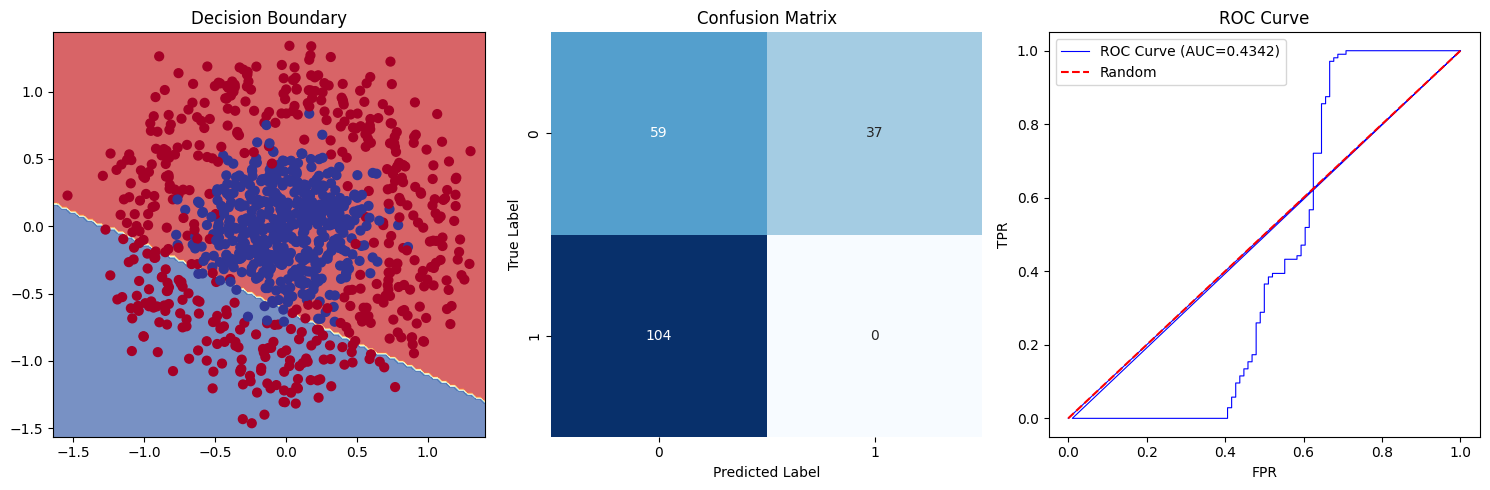

In [14]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Decision Boundary")
plot_decision_boundary(model_0, X_data, y_data)

plt.subplot(1, 3, 2)
plt.title("Confusion Matrix")
plot_confusion_matrix(all_probs, all_labels)

plt.subplot(1, 3, 3)
plt.title("ROC Curve")
plot_roc_auc(all_probs, all_labels)

plt.tight_layout()
plt.show()

### 1.5.6 Check confidence

In [15]:
check_confidence(all_probs, all_labels)

Number of hight confidence errors: 141
Number of low confidence errors: 141


### 1.5.7 Save results

In [16]:
layers = [layer.__class__.__name__ for layer in model_0.layers]
layers_str = ", ".join(layers)

results = pd.DataFrame([[model_0.__class__.__name__, "test", mean_test_loss, acc, precision, recall, f1, layers_str]], columns=["model", "dataset", "loss", "accuracy", "precision", "recall", "f1 score", "layers"])
results

,model,dataset,loss,accuracy,precision,recall,f1 score,layers
0,CircleModelV0,test,0.698213,0.295,0.0,0.0,0.0,"Linear, Linear"


### 1.6.8 Save model

In [17]:
MODEL_0_NAME = "model_0.pth"
MODEL_0_PATH = MODEL_PATH / MODEL_0_NAME

print(f"Saving model to: {MODEL_0_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_0_PATH)

Saving model to: models/model_0.pth


## 1.6 CircleModelV1

### 1.6.1 Model

In [18]:
class CircleModelV1(nn.Module):
    """
    Neural network with linear layers and ReLU activations.
    """
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=12),
            nn.ReLU(),
            nn.Linear(in_features=12, out_features=12),
            nn.ReLU(),
            nn.Linear(in_features=12, out_features=1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=12, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=12, bias=True)
    (3): ReLU()
    (4): Linear(in_features=12, out_features=1, bias=True)
  )
)

### 1.6.2 Loss function and optimizer

In [19]:
loss_fn = nn.BCEWithLogitsLoss(reduction="none")
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.01)

### 1.6.3 Training

In [20]:
eps = 1e-8
N_EPOCHS = 200

total_train_loss = []
total_train_recall = []
total_train_precision = []
total_train_acc = []
total_train_f1 = []

total_val_loss = []
total_val_recall = []
total_val_precision = []
total_val_acc = []
total_val_f1 = []


for epoch in range(N_EPOCHS):

    train_loss = []
    total_samples = 0
    TP_total, TN_total, FP_total, FN_total = 0, 0, 0, 0
    
    train_dataloader = manual_dataloader(train_dataset, batch_size=BATCH_SIZE)
    model_1.train()
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)
        train_logits = model_1(X)
        losses = loss_fn(train_logits, y)
        train_loss.extend(losses.flatten().tolist())

        optimizer.zero_grad()
        losses.mean().backward()
        optimizer.step()
        
        probs = 1 / (1 + torch.exp(-train_logits))
        preds = torch.round(probs)

        TP_total += ((preds == 1) & (y == 1)).sum().item()
        TN_total += ((preds == 0) & (y == 0)).sum().item()
        FP_total += ((preds == 1) & (y == 0)).sum().item()
        FN_total += ((preds == 0) & (y == 1)).sum().item()

        total_samples += len(y)
        
    recall = TP_total / (TP_total + FN_total + eps)
    precision = TP_total / (TP_total + FP_total + eps)
    f1 = 2 * recall * precision / (recall + precision + eps)
    acc = (TP_total + TN_total) / total_samples

    total_train_recall.append(recall)
    total_train_precision.append(precision)
    total_train_f1.append(f1)
    total_train_acc.append(acc)

    mean_train_loss = sum(train_loss) / len(train_loss)
    total_train_loss.append(mean_train_loss)

    val_loss = []
    total_samples = 0
    TP_total, TN_total, FP_total, FN_total = 0, 0, 0, 0
    val_dataloader = manual_dataloader(val_dataset, batch_size=BATCH_SIZE)
    model_1.eval()
    with torch.inference_mode():
        for X, y in val_dataloader:
            X, y = X.to(device), y.to(device)
            val_logits = model_1(X)
            losses = loss_fn(val_logits, y)
            val_loss.extend(losses.flatten().tolist())

            probs = 1 / (1 + torch.exp(-val_logits))
            preds = torch.round(probs)

            TP_total += ((preds == 1) & (y == 1)).sum().item()
            TN_total += ((preds == 0) & (y == 0)).sum().item()
            FP_total += ((preds == 1) & (y == 0)).sum().item()
            FN_total += ((preds == 0) & (y == 1)).sum().item()

            total_samples += len(y)

    recall = TP_total / (TP_total + FN_total + eps)
    precision = TP_total / (TP_total + FP_total + eps)
    f1 = 2 * recall * precision / (recall + precision + eps)
    acc = (TP_total + TN_total) / total_samples

    total_val_recall.append(recall)
    total_val_precision.append(precision)
    total_val_f1.append(f1)
    total_val_acc.append(acc)

    mean_val_loss = sum(val_loss) / len(val_loss)
    total_val_loss.append(mean_val_loss)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{N_EPOCHS}: val_loss={mean_val_loss:.4f} | val_acc={acc:.4f}")

Epoch 0/200: val_loss=0.7053 | val_acc=0.4792
Epoch 10/200: val_loss=0.6905 | val_acc=0.4792
Epoch 20/200: val_loss=0.6836 | val_acc=0.4792
Epoch 30/200: val_loss=0.6781 | val_acc=0.6167
Epoch 40/200: val_loss=0.6724 | val_acc=0.7375
Epoch 50/200: val_loss=0.6656 | val_acc=0.7875
Epoch 60/200: val_loss=0.6569 | val_acc=0.8333
Epoch 70/200: val_loss=0.6458 | val_acc=0.8542
Epoch 80/200: val_loss=0.6316 | val_acc=0.8958
Epoch 90/200: val_loss=0.6140 | val_acc=0.8958
Epoch 100/200: val_loss=0.5925 | val_acc=0.8833
Epoch 110/200: val_loss=0.5670 | val_acc=0.8792
Epoch 120/200: val_loss=0.5376 | val_acc=0.8750
Epoch 130/200: val_loss=0.5046 | val_acc=0.8833
Epoch 140/200: val_loss=0.4688 | val_acc=0.8833
Epoch 150/200: val_loss=0.4313 | val_acc=0.8917
Epoch 160/200: val_loss=0.3926 | val_acc=0.9208
Epoch 170/200: val_loss=0.3539 | val_acc=0.9292
Epoch 180/200: val_loss=0.3171 | val_acc=0.9292
Epoch 190/200: val_loss=0.2831 | val_acc=0.9333


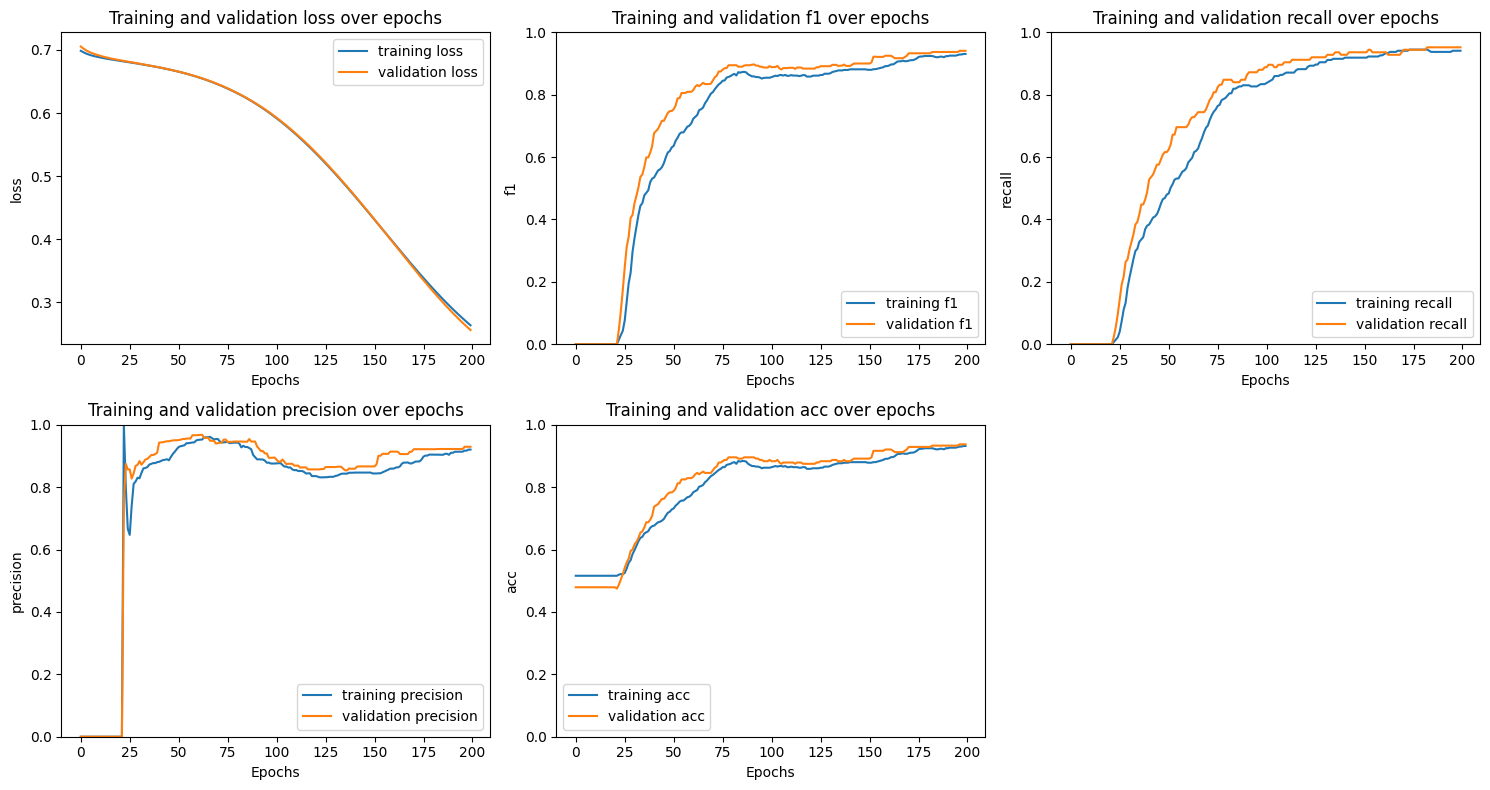

In [21]:
plot_train_val_metrics(
            total_train_loss,
            total_val_loss,
            total_train_f1, 
            total_val_f1,
            total_train_recall,
            total_val_recall,
            total_train_precision,
            total_val_precision,
            total_train_acc,
            total_val_acc,
)

### 1.6.4 Testing

In [22]:
eps = 1e-8
test_loss = []
all_probs = []
all_labels = []
TP_total, TN_total, FP_total, FN_total = 0, 0, 0, 0
test_dataloader = manual_dataloader(test_dataset, batch_size=BATCH_SIZE)
model_1.eval()
with torch.inference_mode():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        test_logits = model_1(X)
        losses = loss_fn(test_logits, y)
        test_loss.extend(losses.flatten().tolist())

        probs = 1 / (1 + torch.exp(-test_logits))
        preds = torch.round(probs)

        TP_total += ((preds == 1) & (y == 1)).sum().item()
        TN_total += ((preds == 0) & (y == 0)).sum().item()
        FP_total += ((preds == 1) & (y == 0)).sum().item()
        FN_total += ((preds == 0) & (y == 1)).sum().item()

        all_probs.append(probs)
        all_labels.append(y)

recall = TP_total / (TP_total + FN_total + eps)
precision = TP_total / (TP_total + FP_total + eps)
f1 = 2 * recall * precision / (recall + precision + eps)
total_samples = sum(y.size(0) for y in all_labels)
acc = (TP_total + TN_total) / total_samples
mean_test_loss = sum(test_loss) / len(test_loss)

all_probs = torch.cat(all_probs)
all_labels = torch.cat(all_labels)

print(f"Test loss: {mean_test_loss:.4f} | Test acc: {acc:.4f}")

Test loss: 0.2434 | Test acc: 0.9400


### 1.6.5 Visualize predictions

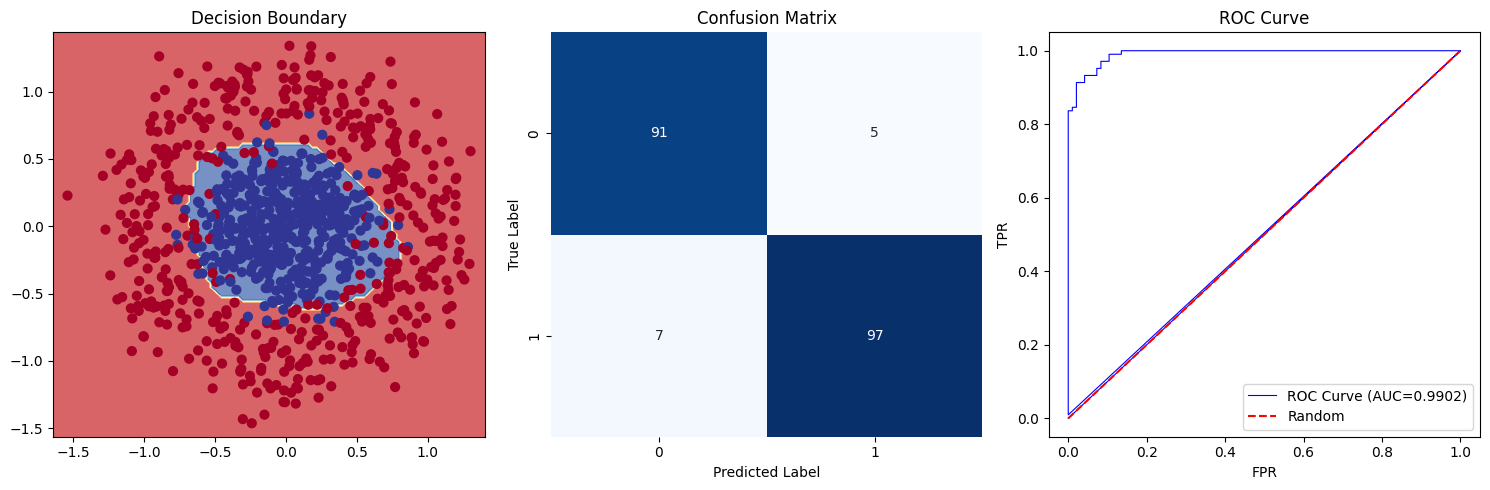

In [23]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Decision Boundary")
plot_decision_boundary(model_1, X_data, y_data)

plt.subplot(1, 3, 2)
plt.title("Confusion Matrix")
plot_confusion_matrix(all_probs, all_labels)

plt.subplot(1, 3, 3)
plt.title("ROC Curve")
plot_roc_auc(all_probs, all_labels)

plt.tight_layout()
plt.show()

### 1.6.6 Check confidence

In [24]:
check_confidence(all_probs, all_labels)

Number of hight confidence errors: 12
Number of low confidence errors: 12


### 1.6.7 Save results

In [25]:
layers = [layer.__class__.__name__ for layer in model_1.layers]

results.loc[len(results)] = [
    model_1.__class__.__name__,
    "test",
    mean_test_loss,
    acc, 
    precision, 
    recall, 
    f1, 
    ", ".join(layers),
]
results

,model,dataset,loss,accuracy,precision,recall,f1 score,layers
0,CircleModelV0,test,0.698213,0.295,0.00000,0.000000,0.000000,"Linear, Linear"
1,CircleModelV1,test,0.243379,0.940,0.95098,0.932692,0.941748,"Linear, ReLU, Linear, ReLU, Linear"


### 1.6.8 Save model

In [26]:
MODEL_1_NAME = "model_1.pth"
MODEL_1_PATH = MODEL_PATH / MODEL_1_NAME

print(f"Saving model to: {MODEL_1_PATH}")
torch.save(obj=model_1.state_dict(), f=MODEL_1_PATH)

Saving model to: models/model_1.pth


## 1.7 CircleModelV2

### 1.7.1 Model

In [27]:
class CircleModelV2(nn.Module):
    """
    Neural Network with linear layers, ReLU activations and Dropout.
    """
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=12),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=12, out_features=12),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=12, out_features=1),
        )


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

model_2 = CircleModelV2().to(device)
model_2

CircleModelV2(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=12, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=12, out_features=12, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=12, out_features=1, bias=True)
  )
)

### 1.7.2 Loss function and optimizer

In [28]:
loss_fn = nn.BCEWithLogitsLoss(reduction="none")
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.01)

### 1.7.3 Training

In [29]:
eps = 1e-8
N_EPOCHS = 200

total_train_loss = []
total_train_recall = []
total_train_precision = []
total_train_f1 = []
total_train_acc = []

total_val_loss = []
total_val_recall = []
total_val_precision = []
total_val_f1 = []
total_val_acc = []

for epoch in range(N_EPOCHS):

    train_loss = []
    total_samples = 0
    TP_total, TN_total, FP_total, FN_total = 0, 0, 0, 0
    
    train_dataloader = manual_dataloader(train_dataset, batch_size=BATCH_SIZE)
    model_2.train()
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)
        train_logits = model_2(X)
        losses = loss_fn(train_logits, y)
        train_loss.extend(losses.flatten().tolist())

        optimizer.zero_grad()
        losses.mean().backward()
        optimizer.step()

        probs = 1 / (1 + torch.exp(-train_logits))
        preds = torch.round(probs)

        TP_total += ((preds == 1) & (y == 1)).sum().item()
        TN_total += ((preds == 0) & (y == 0)).sum().item()
        FP_total += ((preds == 1) & (y == 0)).sum().item()
        FN_total += ((preds == 0) & (y == 1)).sum().item()

        total_samples += len(y)

    recall = TP_total / (TP_total + FN_total + eps)
    precision = TP_total / (TP_total + FP_total + eps)
    f1 = 2 * recall * precision / (recall + precision + eps)
    acc = (TP_total + TN_total) / total_samples

    mean_train_loss = sum(train_loss) / len(train_loss)
    total_train_loss.append(mean_train_loss)
    total_train_recall.append(recall)
    total_train_precision.append(precision)
    total_train_f1.append(f1)
    total_train_acc.append(acc)

    val_loss = []
    total_samples = 0
    TP_total, TN_total, FP_total, FN_total = 0, 0, 0, 0
    
    val_dataloader = manual_dataloader(val_dataset, batch_size=BATCH_SIZE)
    model_2.eval()
    with torch.inference_mode():
        for X, y in val_dataloader:
            X, y = X.to(device), y.to(device)
            val_logits = model_2(X)
            losses = loss_fn(val_logits, y)
            val_loss.extend(losses.flatten().tolist())
            
            probs = 1 / (1 + torch.exp(-val_logits))
            preds = torch.round(probs)

            TP_total += ((preds == 1) & (y == 1)).sum().item()
            TN_total += ((preds == 0) & (y == 0)).sum().item()
            FP_total += ((preds == 1) & (y == 0)).sum().item()
            FN_total += ((preds == 0) & (y == 1)).sum().item()

            total_samples += len(y)

    recall = TP_total / (TP_total + FN_total + eps)
    precision = TP_total / (TP_total + FP_total + eps)
    f1 = 2 * recall * precision / (recall + precision + eps)
    acc = (TP_total + TN_total) / total_samples

    mean_val_loss = sum(val_loss) / len(val_loss)
    total_val_loss.append(mean_val_loss)
    total_val_recall.append(recall)
    total_val_precision.append(precision)
    total_val_f1.append(f1)
    total_val_acc.append(acc)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{N_EPOCHS}: val_loss={mean_val_loss:.4f} | val_acc={acc:.4f}")        

Epoch 0/200: val_loss=0.7073 | val_acc=0.4792
Epoch 10/200: val_loss=0.6922 | val_acc=0.4792
Epoch 20/200: val_loss=0.6820 | val_acc=0.4792
Epoch 30/200: val_loss=0.6724 | val_acc=0.4792
Epoch 40/200: val_loss=0.6635 | val_acc=0.7417
Epoch 50/200: val_loss=0.6532 | val_acc=0.8208
Epoch 60/200: val_loss=0.6410 | val_acc=0.8583
Epoch 70/200: val_loss=0.6259 | val_acc=0.8667
Epoch 80/200: val_loss=0.6082 | val_acc=0.8708
Epoch 90/200: val_loss=0.5884 | val_acc=0.8667
Epoch 100/200: val_loss=0.5668 | val_acc=0.8667
Epoch 110/200: val_loss=0.5434 | val_acc=0.8667
Epoch 120/200: val_loss=0.5193 | val_acc=0.8708
Epoch 130/200: val_loss=0.4947 | val_acc=0.8875
Epoch 140/200: val_loss=0.4691 | val_acc=0.8958
Epoch 150/200: val_loss=0.4432 | val_acc=0.9042
Epoch 160/200: val_loss=0.4166 | val_acc=0.9125
Epoch 170/200: val_loss=0.3926 | val_acc=0.9250
Epoch 180/200: val_loss=0.3678 | val_acc=0.9542
Epoch 190/200: val_loss=0.3457 | val_acc=0.9625


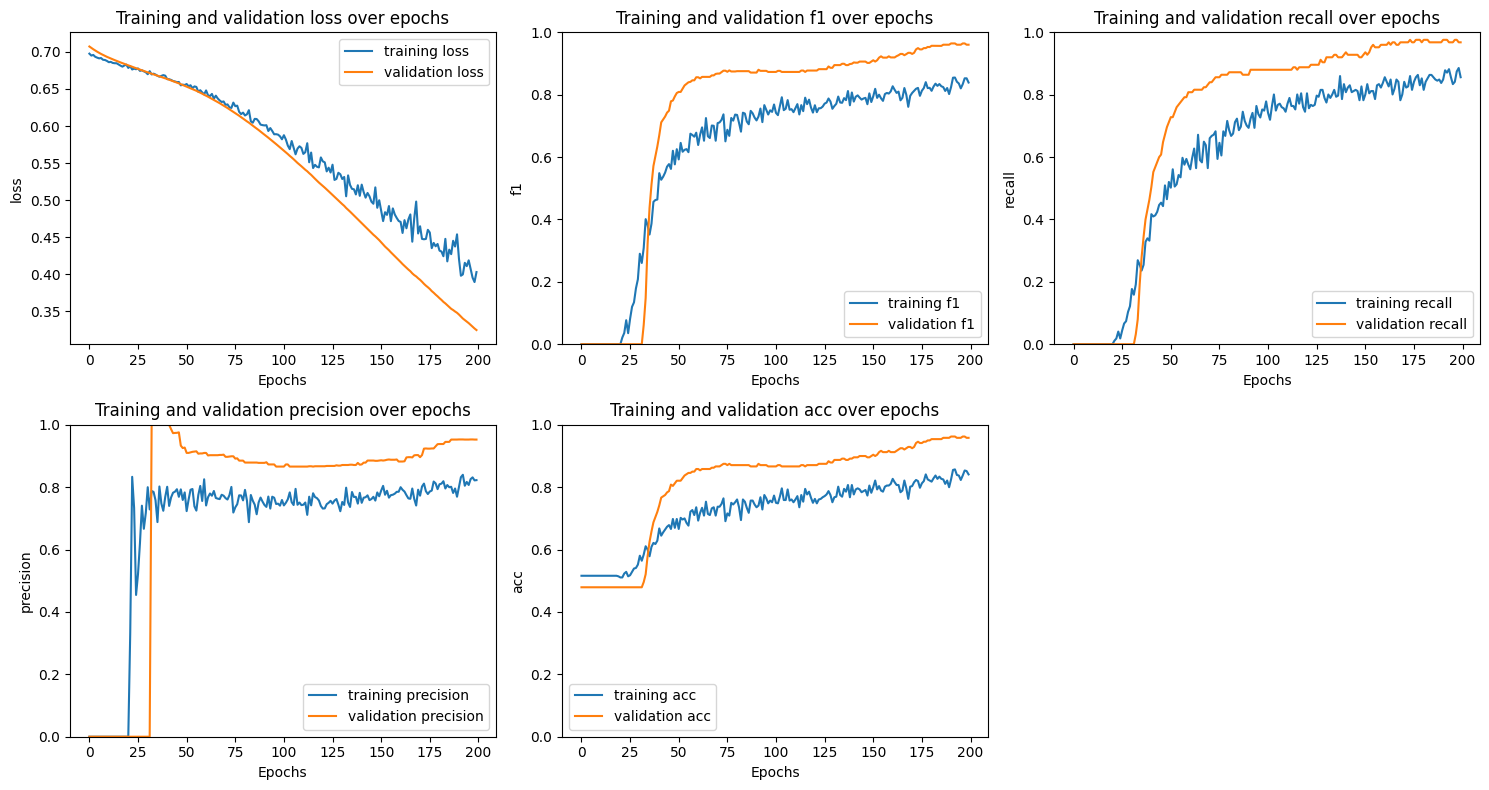

In [30]:
plot_train_val_metrics(
            total_train_loss,
            total_val_loss,
            total_train_f1, 
            total_val_f1,
            total_train_recall,
            total_val_recall,
            total_train_precision,
            total_val_precision,
            total_train_acc,
            total_val_acc,
)

### 1.7.4 Testing

In [31]:
eps = 1e-8
test_loss = []
all_probs = []
all_labels = []

TP_total, TN_total, FP_total, FN_total = 0, 0, 0, 0
test_dataloader = manual_dataloader(test_dataset, batch_size=BATCH_SIZE)
model_2.eval()
with torch.inference_mode():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        test_logits = model_2(X)
        losses = loss_fn(test_logits, y)
        test_loss.extend(losses.flatten().tolist())
        
        probs = 1 / (1 + torch.exp(-test_logits))
        preds = torch.round(probs)

        TP_total += ((preds == 1) & (y == 1)).sum().item()
        TN_total += ((preds == 0) & (y == 0)).sum().item()
        FP_total += ((preds == 1) & (y == 0)).sum().item()
        FN_total += ((preds == 0) & (y == 1)).sum().item()

        all_probs.append(probs)
        all_labels.append(y)

recall = TP_total / (TP_total + FN_total + eps)
precision = TP_total / (TP_total + FP_total + eps)
f1 = 2 * recall * precision / (recall + precision + eps)
total_samples = sum(y.size(0) for y in all_labels)
acc = (TP_total + TN_total) / total_samples
mean_test_loss = sum(test_loss) / len(test_loss)

all_probs = torch.cat(all_probs)
all_labels = torch.cat(all_labels)

print(f"Test loss: {mean_test_loss:.4f} | Test acc: {acc:.4f}")

Test loss: 0.3580 | Test acc: 0.9300


### 1.7.5 Visualize predictions

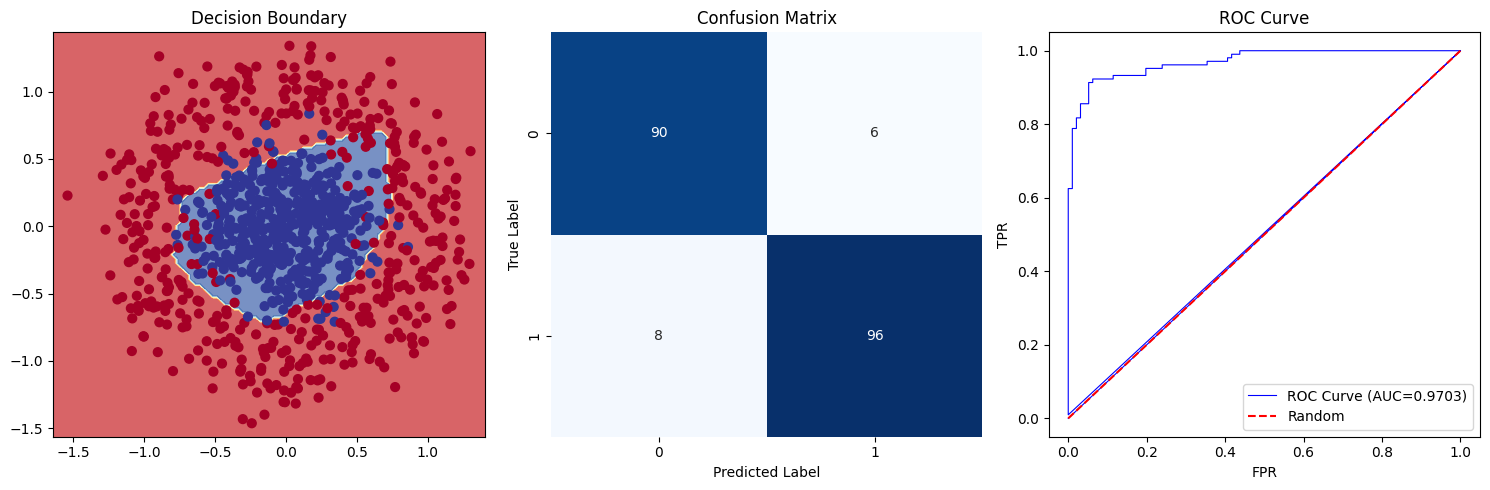

In [32]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Decision Boundary")
plot_decision_boundary(model_2, X_data, y_data)

plt.subplot(1, 3, 2)
plt.title("Confusion Matrix")
plot_confusion_matrix(all_probs, all_labels)

plt.subplot(1, 3, 3)
plt.title("ROC Curve")
plot_roc_auc(all_probs, all_labels)

plt.tight_layout()
plt.show()

### 1.7.6 Check confidence

In [33]:
check_confidence(all_probs, all_labels)

Number of hight confidence errors: 14
Number of low confidence errors: 14


### 1.7.7 Save results

In [34]:
layers = [layer.__class__.__name__ for layer in model_2.layers]

results.loc[len(results)] = [
    model_2.__class__.__name__,
    "test",
    mean_test_loss,
    acc, 
    precision, 
    recall, 
    f1, 
    ", ".join(layers),
]
results

,model,dataset,loss,accuracy,precision,recall,f1 score,layers
0,CircleModelV0,test,0.698213,0.295,0.000000,0.000000,0.000000,"Linear, Linear"
1,CircleModelV1,test,0.243379,0.940,0.950980,0.932692,0.941748,"Linear, ReLU, Linear, ReLU, Linear"
2,CircleModelV2,test,0.358045,0.930,0.941176,0.923077,0.932039,"Linear, ReLU, Dropout, Linear, ReLU, Dropout, Linear"


### 1.7.8 Save model

In [35]:
MODEL_2_NAME = "model_2.pth"
MODEL_2_PATH = MODEL_PATH / MODEL_2_NAME

print(f"Saving model to: {MODEL_2_PATH}")
torch.save(model_2.state_dict(), f=MODEL_2_PATH)

Saving model to: models/model_2.pth


## 1.8 Test on new data

### 1.8.1 Prepare data

In [36]:
N_SAMPLES = 1000
NOISE = 0.3    # different than previous
FACTOR = 0.2   # different than previous
RANDOM_STATE = 42

In [37]:
X_new, y_new = make_circles(N_SAMPLES, noise=NOISE, random_state=RANDOM_STATE, factor=FACTOR)

X_new = torch.tensor(X_new, dtype=torch.float32).to(device)
y_new = torch.tensor(y_new, dtype=torch.float32).view(-1, 1).to(device)

### 1.8.2 Load models

In [38]:
model_0 = CircleModelV0().to(device)
model_0.load_state_dict(torch.load(f=MODEL_0_PATH))

model_1 = CircleModelV1().to(device)
model_1.load_state_dict(torch.load(f=MODEL_1_PATH))

model_2 = CircleModelV2().to(device)
model_2.load_state_dict(torch.load(f=MODEL_2_PATH))

<All keys matched successfully>

### 1.8.3 Loss function

In [39]:
loss_fn = nn.BCEWithLogitsLoss()

### 1.8.4 Testing `CircleModelV0`

In [40]:
eps = 1e-8
model_0.eval()
with torch.inference_mode():
    logits = model_0(X_new)
    loss = loss_fn(logits, y_new)
    probs = 1 / (1 + torch.exp(-logits))
    preds = torch.round(probs)

    TP = ((preds == 1) & (y_new == 1)).sum().item()
    TN = ((preds == 0) & (y_new == 0)).sum().item()
    FP = ((preds == 1) & (y_new == 0)).sum().item()
    FN = ((preds == 0) & (y_new == 1)).sum().item()

    recall = TP / (TP + FN + eps)
    precision = TP / (TP + FP + eps)
    f1 = 2 * recall * precision / (recall + precision + eps)
    acc = (TP + TN) / len(y_new)
    
    print(f"Test loss: {loss.item():.4f} | Test acc: {acc:.4f}")


Test loss: 0.6940 | Test acc: 0.3790


In [41]:
results.loc[len(results)] = [
    model_0.__class__.__name__,
    "external",
    loss.item(),
    acc,
    precision,
    recall,
    f1,
    ", ".join([layer.__class__.__name__ for layer in model_0.layers])
]
results

,model,dataset,loss,accuracy,precision,recall,f1 score,layers
0,CircleModelV0,test,0.698213,0.295,0.000000,0.000000,0.000000,"Linear, Linear"
1,CircleModelV1,test,0.243379,0.940,0.950980,0.932692,0.941748,"Linear, ReLU, Linear, ReLU, Linear"
2,CircleModelV2,test,0.358045,0.930,0.941176,0.923077,0.932039,"Linear, ReLU, Dropout, Linear, ReLU, Dropout, Linear"
3,CircleModelV0,external,0.694007,0.379,0.142012,0.048000,0.071749,"Linear, Linear"


### 1.8.5 Testing `CircleModelV1`

In [42]:
eps = 1e-8
model_1.eval()
with torch.inference_mode():
    logits = model_1(X_new)
    loss = loss_fn(logits, y_new)
    probs = 1 / (1 + torch.exp(-logits))
    preds = torch.round(probs)

    TP = ((preds == 1) & (y_new == 1)).sum().item()
    TN = ((preds == 0) & (y_new == 0)).sum().item()
    FP = ((preds == 1) & (y_new == 0)).sum().item()
    FN = ((preds == 0) & (y_new == 1)).sum().item()

    recall = TP / (TP + FN + eps)
    precision = TP / (TP + FP + eps)
    f1 = 2 * recall * precision / (recall + precision)
    acc = (TP + TN) / len(y_new)

    print(f"Test loss: {loss.item():.4f} | Test acc: {acc:.4f}")


Test loss: 0.3313 | Test acc: 0.8700


In [43]:
results.loc[len(results)] = [
    model_1.__class__.__name__,
    "external",
    loss.item(),
    acc,
    precision,
    recall,
    f1,
    ", ".join([layer.__class__.__name__ for layer in model_1.layers])
]
results

,model,dataset,loss,accuracy,precision,recall,f1 score,layers
0,CircleModelV0,test,0.698213,0.295,0.000000,0.000000,0.000000,"Linear, Linear"
1,CircleModelV1,test,0.243379,0.940,0.950980,0.932692,0.941748,"Linear, ReLU, Linear, ReLU, Linear"
2,CircleModelV2,test,0.358045,0.930,0.941176,0.923077,0.932039,"Linear, ReLU, Dropout, Linear, ReLU, Dropout, Linear"
3,CircleModelV0,external,0.694007,0.379,0.142012,0.048000,0.071749,"Linear, Linear"
4,CircleModelV1,external,0.331282,0.870,0.867063,0.874000,0.870518,"Linear, ReLU, Linear, ReLU, Linear"


### 1.8.6 Testing `CircleModelV2`

In [44]:
eps = 1e-8
model_2.eval()
with torch.inference_mode():
    logits = model_2(X_new)
    loss = loss_fn(logits, y_new)
    probs = 1 / (1 + torch.exp(-logits))
    preds = torch.round(probs)

    TP = ((preds == 1) & (y_new == 1)).sum().item()
    TN = ((preds == 0) & (y_new == 0)).sum().item()
    FP = ((preds == 1) & (y_new == 0)).sum().item()
    FN = ((preds == 0) & (y_new == 1)).sum().item()

    recall = TP / (TP + FN + eps)
    precision = TP / (TP + FP + eps)
    f1 = 2 * recall * precision / (recall + precision + eps)
    acc = (TP + TN) / len(y_new)

    print(f"Test loss: {loss.item():.4f} | Test acc: {acc:.4f}")


Test loss: 0.3890 | Test acc: 0.8680


In [45]:
results.loc[len(results)] = [
    model_2.__class__.__name__,
    "external",
    loss.item(),
    acc,
    precision,
    recall,
    f1,
    ", ".join([layer.__class__.__name__ for layer in model_2.layers])
]
results

,model,dataset,loss,accuracy,precision,recall,f1 score,layers
0,CircleModelV0,test,0.698213,0.295,0.000000,0.000000,0.000000,"Linear, Linear"
1,CircleModelV1,test,0.243379,0.940,0.950980,0.932692,0.941748,"Linear, ReLU, Linear, ReLU, Linear"
2,CircleModelV2,test,0.358045,0.930,0.941176,0.923077,0.932039,"Linear, ReLU, Dropout, Linear, ReLU, Dropout, Linear"
3,CircleModelV0,external,0.694007,0.379,0.142012,0.048000,0.071749,"Linear, Linear"
4,CircleModelV1,external,0.331282,0.870,0.867063,0.874000,0.870518,"Linear, ReLU, Linear, ReLU, Linear"
5,CircleModelV2,external,0.388998,0.868,0.862205,0.876000,0.869048,"Linear, ReLU, Dropout, Linear, ReLU, Dropout, Linear"
